In [1]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import torch
import pickle

from itertools import combinations
from tqdm import tqdm
from matplotlib.colors import LogNorm

molecule = "2F4K"
# molecule = "2JOF"
# molecule = "CLN025"
simulation_idx = 0
base_dir = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-protein"
pdb_file = f"../data/{molecule}/{molecule}_from_mae.pdb"

# Basics

1.4736894


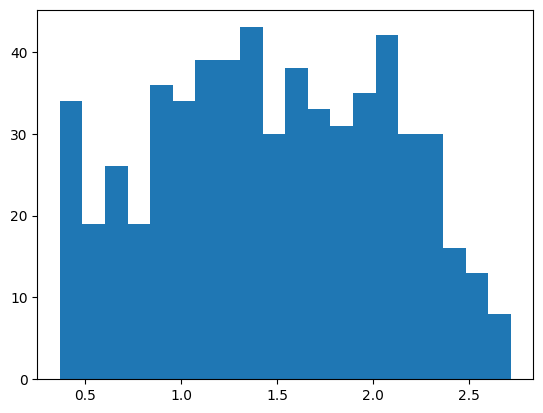

In [7]:
traj = md.load(
	f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/{molecule}_from_mae.pdb"
)
ca_resid_pair = np.array(
    [(a.index, b.index) for a, b in combinations(list(traj.topology.residues), 2)]
)
ca_distance, _ = md.compute_contacts(
	traj, scheme="ca", contacts=ca_resid_pair, periodic=False
)
print(ca_distance.mean())
plt.hist(ca_distance.flatten(), bins=20)
plt.show()

In [8]:
# Count the number of .dcd files in the simulation directory
dcd_pattern = f"{base_dir}/{molecule}-{simulation_idx}-protein-*.dcd"
dcd_files = glob.glob(dcd_pattern)
num_files = len(dcd_files)

print(f"Found {num_files} .dcd files in {base_dir}")
print(f"Pattern used: {dcd_pattern}")

# Extract the indices from filenames and sort them
file_indices = []
for file_path in dcd_files:
    filename = os.path.basename(file_path)
    # Extract the index from filename like "2JOF-0-protein-000.dcd"
    index_part = filename.split('-')[-1].replace('.dcd', '')
    if index_part.isdigit():
        file_indices.append(int(index_part))

file_indices.sort()
print(f"File indices range: {min(file_indices)} to {max(file_indices)}")
print(f"Total files to load: {len(file_indices)}")

Found 63 .dcd files in /home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_2F4K-0-protein/2F4K-0-protein
Pattern used: /home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_2F4K-0-protein/2F4K-0-protein/2F4K-0-protein-*.dcd
File indices range: 0 to 62
Total files to load: 63


In [9]:
traj_list = []

for i in tqdm(
    range(len(file_indices)),
    desc="Loading trajectories"
):
    file_idx = f"{i:03d}"
    traj = md.load_dcd(
        f"{base_dir}/{molecule}-0-protein-{file_idx}.dcd",
        top=pdb_file,
    )
    traj_list.append(traj)

all_traj = md.join(traj_list)
print(f"Number of frames: {all_traj.n_frames}")

Loading trajectories: 100%|██████████| 63/63 [00:03<00:00, 17.14it/s]


Number of frames: 627907


In [10]:
ca_resid_pair = np.array(
    [(a.index, b.index) for a, b in combinations(list(traj.topology.residues), 2)]
)
all_traj_ca_pair_distances, _ = md.compute_contacts(
	all_traj, scheme="ca", contacts=ca_resid_pair, periodic=False
)
print(all_traj_ca_pair_distances.shape)

(627907, 595)


In [11]:
def cad2switch(
    cad,
    cutoff: float = 0.8
) -> np.ndarray:
	if type(cad) == torch.Tensor:
		cad = cad.numpy()
	return (1 - np.power(cad / cutoff, 6)) / (1 - np.power(cad / cutoff, 12))

In [12]:
# # CA pair distance

# all_traj_ca_pair_distances_switch = cad2switch(all_traj_ca_pair_distances)

# torch.save(torch.from_numpy(all_traj.xyz), f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-pos.pt")
# torch.save(torch.from_numpy(all_traj_ca_pair_distances), f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-cad.pt")
# torch.save(torch.from_numpy(all_traj_ca_pair_distances_switch), f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-cad-switch.pt")

In [13]:
loaded_xyz = torch.load(f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-pos.pt")
loaded_cad = torch.load(f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-cad.pt")
loaded_cad_switch = torch.load(f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-cad-switch.pt")

print(loaded_xyz.shape)
print(loaded_cad.shape)
print(loaded_cad_switch.shape)

torch.Size([627907, 577, 3])
torch.Size([627907, 595])
torch.Size([627907, 595])


# Small size dataset generation

## Position and CAD

In [8]:
simulation_idx = 0
molecule_cad_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-cad.pt"
molecule_pos_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-pos.pt"
cad_data = torch.load(molecule_cad_path)
pos_data = torch.load(molecule_pos_path)

print(cad_data.shape)
print(pos_data.shape)

torch.Size([627907, 595])
torch.Size([627907, 577, 3])


In [9]:
def coord2rot(
    pdb,
    coordinates,
):
    ca_indices = pdb.topology.select('name CA')
    n_indices = pdb.topology.select('name N')
    c_indices = pdb.topology.select('name C')
    pdb_xyz = torch.tensor(coordinates)

    a = pdb_xyz[:, ca_indices]
    b = pdb_xyz[:, n_indices]
    c = pdb_xyz[:, c_indices]

    u = b - a  # C_alpha -> N
    v = c - a  # C_alpha -> C

    # Gram-Schmidt Process
    e1 = u / torch.norm(u, dim=-1, keepdim=True)
    u2 = v - torch.sum(e1 * v, dim=-1, keepdim=True) * e1
    e2 = u2 / torch.norm(u2, dim=-1, keepdim=True)
    e3 = torch.cross(e1, e2, dim=-1)

    Q = torch.stack([e1, e2, e3], dim=-1)

    return Q

In [10]:
pdb = md.load_pdb(pdb_file)
orientation = coord2rot(pdb, pos_data.numpy())

print(pos_data.shape)
print(orientation.shape)

torch.Size([627907, 577, 3])
torch.Size([627907, 35, 3, 3])


In [14]:
time_lag_list = [1, 5, 10, 100]
data_num = all_traj.n_frames
dataset_size = 50000
num_data_str = str(dataset_size // 1000) + "k"
selected_idx = torch.from_numpy(np.random.choice(data_num - max(time_lag_list) - 1, size = dataset_size, replace=False))
print(f"Dataset size: {num_data_str}")

Dataset size: 50k


In [ ]:

# Current information
current_pos = pos_data[selected_idx]
current_cad = cad_data[selected_idx]
current_orientation = orientation[selected_idx]
torch.save(current_pos, f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{num_data_str}/current-pos.pt")
torch.save(current_cad, f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{num_data_str}/current-cad.pt")
torch.save(current_orientation, f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{num_data_str}/current-orientation.pt")

# Time-lagged information
for time_lag in time_lag_list:
	print(time_lag)
	next_pos = pos_data[selected_idx + time_lag]
	next_cad = cad_data[selected_idx + time_lag]
	next_orientation = orientation[selected_idx + time_lag]
	torch.save(next_pos, f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{num_data_str}/lag{time_lag}-pos.pt")
	torch.save(next_cad, f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{num_data_str}/lag{time_lag}-cad.pt")
	torch.save(next_orientation, f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{num_data_str}/lag{time_lag}-orientation.pt")

## Label

In [15]:
def label_by_rmsd(
	traj,
	reference_traj,
	cutoff=0.3
):
	rmsd = md.rmsd(traj, reference_traj)
	return rmsd < cutoff

In [ ]:
folded_pdb = md.load(f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/folded.pdb")
current_pos = torch.load(f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{num_data_str}/current-pos.pt")
all_traj.xyz = current_pos.numpy()
current_label = label_by_rmsd(
	traj = all_traj,
	reference_traj = folded_pdb,
	cutoff = 0.4 if molecule == "2F4K" else 0.3
)
torch.save(torch.from_numpy(current_label), f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{num_data_str}/current-label.pt")

for selected_lag in [1, 5, 10, 100]:
	time_lagged_pos = torch.load(f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{num_data_str}/lag{selected_lag}-pos.pt")
	all_traj.xyz = time_lagged_pos.numpy()
	time_lagged_label = label_by_rmsd(all_traj, folded_pdb)
	torch.save(torch.from_numpy(time_lagged_label), f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{num_data_str}/lag{selected_lag}-label.pt")

In [18]:
num_data_str = "50k"
current_label_path = f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{num_data_str}/current-label.pt"
current_label = torch.load(current_label_path)
print(current_label.sum() )

tensor(8421)


# Stats

## CAD, pos stats

In [14]:
dataset_size_str = "5k"
selected_lag = 5

current_pos = torch.load(f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{dataset_size_str}/current-pos.pt")
current_cad = torch.load(f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{dataset_size_str}/current-cad.pt")
time_lagged_pos = torch.load(f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{dataset_size_str}/lag{selected_lag}-pos.pt")
time_lagged_cad = torch.load(f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-{dataset_size_str}/lag{selected_lag}-cad.pt")

print(current_pos.shape)
print(current_cad.shape)
print(time_lagged_pos.shape)
print(time_lagged_cad.shape)

torch.Size([5000, 272, 3])
torch.Size([5000, 190])
torch.Size([5000, 272, 3])
torch.Size([5000, 190])


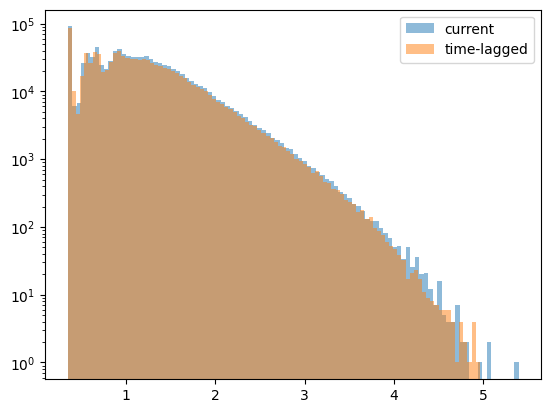

Current CAD mean: 1.1419
Time-lagged CAD mean: 1.1408
Current CAD max: 5.3994
Time-lagged CAD max: 4.9646


In [15]:
plt.hist(current_cad.flatten(), bins=100, alpha=0.5, log=True, label="current")
plt.hist(time_lagged_cad.flatten(), bins=100, alpha=0.5, log=True, label="time-lagged")
plt.legend()
plt.show()

print(f"Current CAD mean: {current_cad.mean():.4f}")
print(f"Time-lagged CAD mean: {time_lagged_cad.mean():.4f}")
print(f"Current CAD max: {current_cad.max():.4f}")
print(f"Time-lagged CAD max: {time_lagged_cad.max():.4f}")

## ETC